# Fingerprint pair bit coverages

We investigate the bit coverage of the fingerprint pairs in the `kissim` dataset.

List the following numbers based on (a) all distances and (b) only distances matching a given bit coverage cutoff
- Number of structures
- Number of structure pairs (theory)
- Number of structure pairs (experimental)
- Number of kinases
- Number of kinase pairs (theory)
- Number of kinase pairs (experimental)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kissim.comparison import FingerprintDistanceGenerator
from kissim.encoding import FingerprintGenerator

from src.paths import PATH_RESULTS

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = PATH_RESULTS / "dfg_in"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.75

## Load fingerprints

In [7]:
fingerprints = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")

In [8]:
fingerprint_bits = [
    fingerprint.values_array(True, True, True) for _, fingerprint in fingerprints.data.items()
]
fingerprint_bits = pd.DataFrame(fingerprint_bits)

In [9]:
fingerprint_bits.shape

(4112, 1032)

### Fingerprint bit coverage

In [10]:
fingerprint_coverage = 100 - fingerprint_bits.isna().sum(axis=1) / fingerprint_bits.shape[0] * 100
fingerprint_coverage = fingerprint_coverage.sort_values(ascending=False)
fingerprint_coverage.name = "Fingerprint coverage"

<AxesSubplot:>

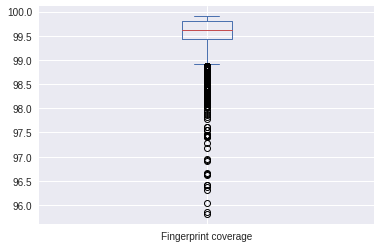

In [11]:
fingerprint_coverage.plot(kind="box")

In [12]:
fingerprint_coverage.describe()

count    4112.000000
mean       99.518533
std         0.440214
min        95.817121
25%        99.440661
50%        99.610895
75%        99.805447
max        99.902724
Name: Fingerprint coverage, dtype: float64

## Load fingerprint distances

In [13]:
fingerprint_distance_file = RESULTS / "fingerprint_distances.csv.bz2"

In [14]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)

In [15]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 257
Number of structures: 4112


In [16]:
structure_distances = fingerprint_distance_generator.data

### Sort fingerprint/kinase pairs (alphabetically)

In [17]:
%%time

structure_distances["structure_pair"] = (
    structure_distances[["structure.1", "structure.2"]].apply(list, axis=1).apply(sorted)
)
structure_distances["kinase_pair"] = (
    structure_distances[["kinase.1", "kinase.2"]].apply(list, axis=1).apply(sorted)
)

structure_distances["structure.1"] = [i[0] for i in structure_distances["structure_pair"]]
structure_distances["structure.2"] = [i[1] for i in structure_distances["structure_pair"]]
structure_distances["kinase.1"] = [i[0] for i in structure_distances["kinase_pair"]]
structure_distances["kinase.2"] = [i[1] for i in structure_distances["kinase_pair"]]
structure_distances = structure_distances.drop(["structure_pair", "kinase_pair"], axis=1)
structure_distances.head()

CPU times: user 2min 4s, sys: 2.06 s, total: 2min 6s
Wall time: 2min 6s


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,4,8,EphA7,ITK,0.064311,0.954000
1,4,9,EphA7,ITK,0.094182,0.985333
2,4,11,EphA7,ITK,0.075470,0.977333
3,4,12,EphA7,ITK,0.066460,0.962000
4,4,16,EphA7,ITK,0.075279,0.985333


## Fingerprint pair coverage

### Coverage between fingerprint pairs

In [18]:
COVERAGE_CUTOFF = 0.8

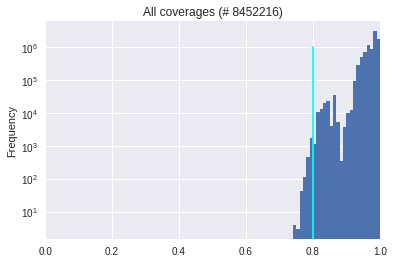

In [19]:
fig, ax = plt.subplots(1, 1)
structure_distances["bit_coverage"].plot(
    kind="hist",
    title=f"All coverages (# {structure_distances.shape[0]})",
    bins=np.arange(0, 1.05, 0.01),
    xlim=(0, 1),
    logy=True,
)
ax.plot([COVERAGE_CUTOFF, COVERAGE_CUTOFF], [0, 1000000], color="cyan")

We might want to filter out some fingerprint pairs because the coverage is super low.

In [20]:
structure_distances["bit_coverage"].describe()

count    8.452216e+06
mean     9.731900e-01
std      2.309928e-02
min      7.466667e-01
25%      9.613333e-01
50%      9.833333e-01
75%      9.873333e-01
max      9.966667e-01
Name: bit_coverage, dtype: float64

### Filter distances by coverage cutoff

In [21]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["bit_coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,distance_filtered
0,4,8,EphA7,ITK,0.064311,0.954000,0.064311
1,4,9,EphA7,ITK,0.094182,0.985333,0.094182
2,4,11,EphA7,ITK,0.075470,0.977333,0.075470
3,4,12,EphA7,ITK,0.066460,0.962000,0.066460
4,4,16,EphA7,ITK,0.075279,0.985333,0.075279


In [22]:
structure_distances_filtered = structure_distances[
    structure_distances["distance_filtered"].notna()
]

In [23]:
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 8452216
Structure pairs not-NaN: 8449868


### Number of kinases/structures (pairs)

In [24]:
def n_pairs(n):
    return int((n ** 2 - n) / 2 + n)

In [25]:
n_structures = (
    pd.concat([structure_distances["structure.1"], structure_distances["structure.2"]])
    .unique()
    .shape[0]
)
n_kinases = (
    pd.concat([structure_distances["kinase.1"], structure_distances["kinase.2"]]).unique().shape[0]
)
n_structures_filtered = (
    pd.concat(
        [structure_distances_filtered["structure.1"], structure_distances_filtered["structure.2"]]
    )
    .unique()
    .shape[0]
)
n_kinases_filtered = (
    pd.concat([structure_distances_filtered["kinase.1"], structure_distances_filtered["kinase.2"]])
    .unique()
    .shape[0]
)


table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0],
        n_kinases,
        n_pairs(n_kinases),
        structure_distances.groupby(["kinase.1", "kinase.2"]).size().shape[0],
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        structure_distances_filtered.groupby(["kinase.1", "kinase.2"]).size().shape[0],
    ],
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ],
)
table

,All distances,Only distances matching cutoff
Number of structures,4112,4112
Number of structure pairs (theory),8456328,8456328
Number of structure pairs (experimental),8452216,8449868
Number of kinases,257,257
Number of kinase pairs (theory),33153,33153
Number of kinase pairs (experimental),33091,33072


## Structure/kinase fingerprint/pairs counts

In [26]:
stats = {}
coverage_min = 0.8
for subset in ["all", "dfg_in", "dfg_out"]:
    print(subset)
    fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(
        HERE / f"../../results/{subset}/fingerprint_distances.csv.bz2"
    )
    n_kinases = len(fingerprint_distance_generator.kinase_ids)
    n_structures = len(fingerprint_distance_generator.structure_ids)
    n_kinases_pairs = len(fingerprint_distance_generator.kinase_distance_matrix())
    n_structure_pairs = len(fingerprint_distance_generator.data)
    n_kinase_pairs_cutoff = len(
        fingerprint_distance_generator.kinase_distance_matrix(coverage_min=coverage_min)
    )
    n_structure_pairs_cutoff = len(
        fingerprint_distance_generator.data[
            fingerprint_distance_generator.data["bit_coverage"] >= coverage_min
        ]
    )
    stats[subset] = [
        n_kinases,
        n_structures,
        n_kinases_pairs,
        n_structure_pairs,
        n_kinase_pairs_cutoff,
        n_structure_pairs_cutoff,
    ]

all
dfg_in
dfg_out


In [27]:
stats = pd.DataFrame(
    stats,
    index=[
        "Number of kinases",
        "Number of structures",
        "Number of kinase pairs",
        "Number of structure pairs",
        "Number of kinase pairs*",
        "Number of structure pairs*",
    ],
)

In [28]:
stats.iloc[[1, 0, 5, 4], :].to_csv(HERE / "../../notebooks/figures/kissim_dataset.csv")

In [29]:
stats.iloc[[1, 0, 5, 4], :]

,all,dfg_in,dfg_out
Number of structures,4681,4112,406
Number of kinases,279,257,71
Number of structure pairs*,10948918,8449868,82215
Number of kinase pairs*,279,257,71
